In [17]:
import scipy as sp
import numpy as np

import matplotlib.pyplot as plt

from scipy.signal import find_peaks

数据集

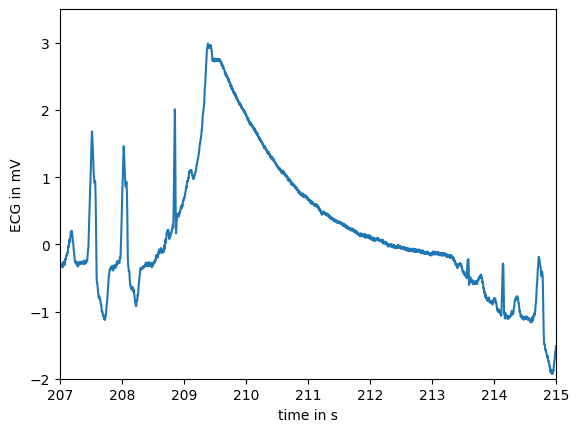

In [18]:
from scipy.datasets import electrocardiogram

ecg = electrocardiogram()
time = np.arange(ecg.size) / 360

plt.plot(time, ecg)
plt.xlabel("time in s")
plt.ylabel("ECG in mV")
plt.xlim(207, 215)
plt.ylim(-2, 3.5)
plt.show()

寻找峰值点

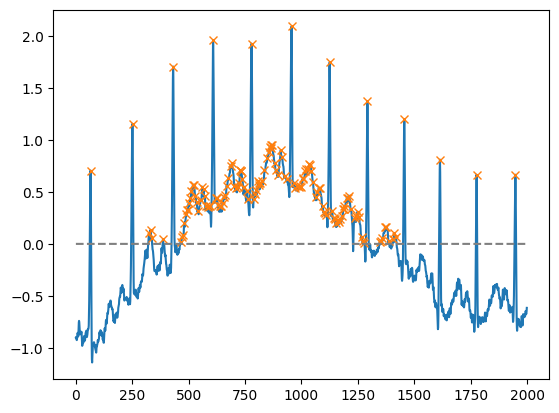

In [19]:
x = electrocardiogram()[2000:4000]
peaks, _ = find_peaks(x, height=0)


plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()

快速傅里叶变换（fft）

In [20]:
y = sp.fft.fft(x)

x_ori = sp.fft.ifft(y)
x_ori

array([-0.9  -1.42108547e-17j, -0.895-2.31481501e-17j,
       -0.895-5.32907052e-18j, ..., -0.67 -3.72881507e-17j,
       -0.65 -9.48182208e-17j, -0.615+2.78659009e-17j])

矩阵逆

In [21]:
m = np.array([[1.0, 2.0], [3.0, 4.0]])

m_inv = np.linalg.inv(m)
m_inv_inv = np.linalg.inv(m_inv)

np.allclose(m, m_inv_inv)

True

In [22]:
m_inv_3 = sp.linalg.inv(m_inv_inv)
np.allclose(m_inv_3, m_inv)

True

病态矩阵的逆

In [23]:
m_ill = np.array([[2, 4, 6], [2, 0, 2], [6, 8, 14]])
m_inv = np.linalg.inv(m_ill)

np.allclose(m_inv @ m_ill, np.eye(3))

False

矩阵条件数

In [24]:
print(f"m_ill:{np.linalg.cond(m_ill):.5f}")
print(f"m:{np.linalg.cond(m):.5f}")

m_ill:865988563411866752.00000
m:14.93303


SVD矩阵分解

It is also possible to detect ill-conditioning by inspecting the matrix’s singular values directly.

In [25]:
sigma = np.linalg.svd(m_ill, compute_uv=False)
print(f"ill-conditioned:{sigma.max() / sigma.min():.5f}")

ill-conditioned:865988563411866752.00000


对非方阵求伪逆

In [26]:
rng = np.random.default_rng()
mn = rng.normal(size=(9, 6))

mn_pinv = np.linalg.pinv(mn)
np.allclose(mn_pinv @ mn, np.eye(6))

True

multivariate normal

<Figure size 640x480 with 0 Axes>

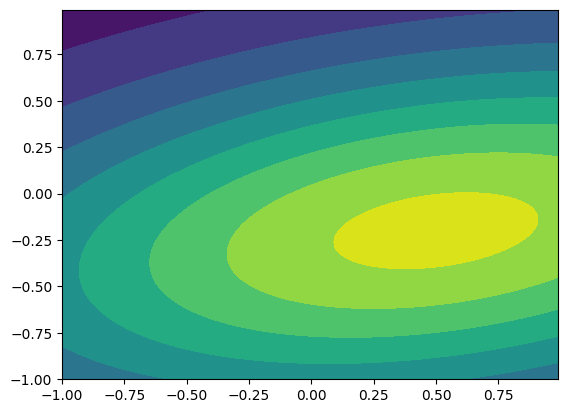

In [27]:
rv = sp.stats.multivariate_normal([0.5, -0.2], [[2.0, 0.3], [0.3, 0.5]])

x, y = np.mgrid[-1:1:0.01, -1:1:0.01]
pos = np.dstack((x, y))

fig = plt.figure()
_, ax = plt.subplots()
ax.contourf(x, y, rv.pdf(pos))

# explore Gaussian process regression

https://andrewcharlesjones.github.io/journal/gaussian-processes.html

In [28]:
def gaussian_kernel(x1, x2):
    return np.exp(-0.5 * (x1 - x2) ** 2)


kernel = gaussian_kernel

Drawing from GP prior:

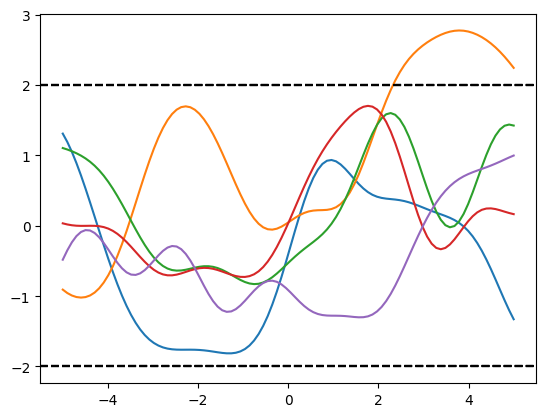

In [29]:
n = 100

for _ in range(5):
    X = np.linspace(-5, 5, n)
    K = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            curr_k = kernel(X[i], X[j])
            K[i, j] = curr_k
            K[j, i] = curr_k

    Y = sp.stats.multivariate_normal(mean=np.zeros(n), cov=K, allow_singular=True).rvs()

    plt.axhline(-2, linestyle="--", c="black")
    plt.axhline(2, linestyle="--", c="black")
    plt.plot(X, Y)

Visualizing joint distributions:

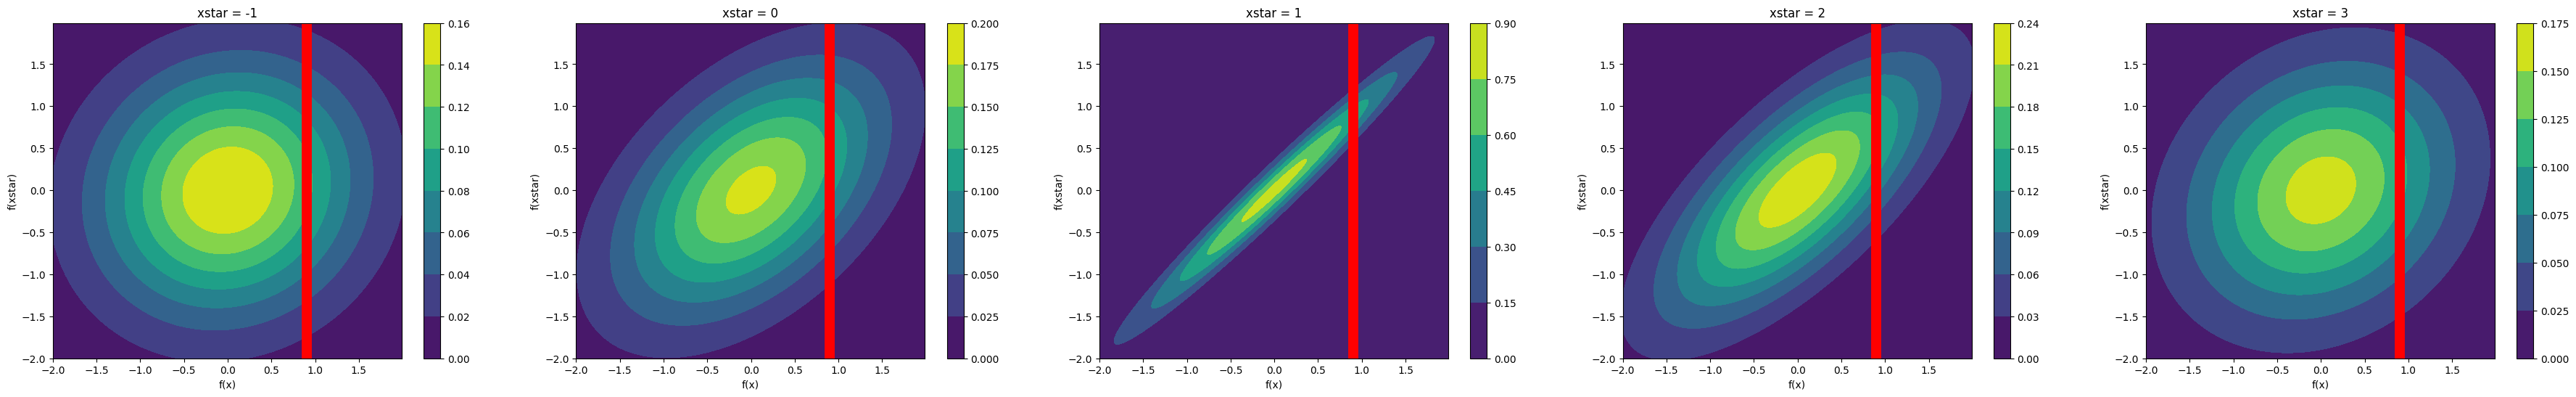

In [30]:
plt.figure(figsize=(45, 6))

xtrain, ytrain = 1.2, 0.9
xstar_list = [-1, 0, 1, 2, 3]

for iter_num, xstar in enumerate(xstar_list):
    # Get kernel matrix
    K = np.array([[kernel(xtrain, xtrain), kernel(xtrain, xstar)], [kernel(xstar, xtrain), kernel(xstar, xstar)]])

    x, y = np.mgrid[-2:2:0.01, -2:2:0.01]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x
    pos[:, :, 1] = y
    rv = sp.stats.multivariate_normal(np.zeros(2), cov=K)

    plt.subplot(1, len(xstar_list), iter_num + 1)
    plt.contourf(x, y, rv.pdf(pos))
    cbar = plt.colorbar()
    plt.title("xstar = {}".format(xstar))
    plt.xlabel("f(x)")
    plt.ylabel("f(xstar)")
    plt.axvline(ytrain, c="red", linewidth=10)

Predictions in GP regression:

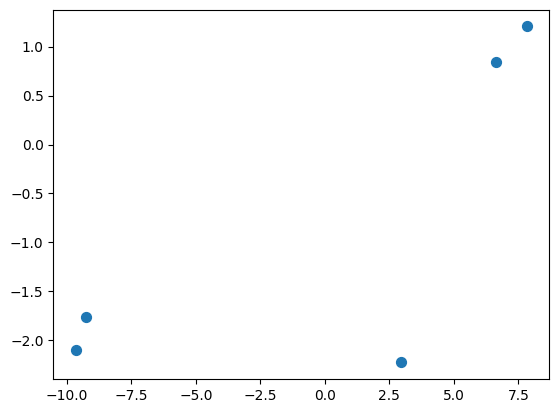

In [31]:
plt.figure()
left_endpoint, right_endpoint = -10, 10

# Draw x samples
n = 5
X = np.random.uniform(low=left_endpoint, high=right_endpoint, size=n)

# Form covariance matrix between samples
K11 = np.zeros((n, n))
for ii in range(n):
    for jj in range(n):
        curr_k = kernel(X[ii], X[jj])
        K11[ii, jj] = curr_k

# Draw Y from MVN
Y = sp.stats.multivariate_normal(mean=np.zeros(n), cov=K11, allow_singular=True).rvs()

plt.scatter(X, Y, s=50)

Given the training data $X \in \mathbb{R}^{n \times n}$ and the test data $X' \in \mathbb{R}^{n \times n'}$, we know that they are jointly Guassian:

\begin{bmatrix}\mathbf{f}\\\mathbf{f}^\star\end{bmatrix}\sim\mathcal{N}_{n+m}\left(\mathbf{0},\begin{bmatrix}K(\mathbf{X},\mathbf{X})&K(\mathbf{X},\mathbf{X}^\star)\\K(\mathbf{X}^\star,\mathbf{X})&K(\mathbf{X}^\star,\mathbf{X}^\star)\end{bmatrix}\right).

The conditional distribution will be

$$\mathbf{f}^\star|\mathbf{f}\sim\mathcal{N}\left(K_{\mathbf{x}\mathbf{x}^\star}K_{\mathbf{x}^\star\mathbf{x}^\star}^{-1}\mathbf{f},K_{\mathbf{x}\mathbf{x}}-K_{\mathbf{x}\mathbf{x}^\star}K_{\mathbf{x}^\star\mathbf{x}^\star}^{-1}K_{\mathbf{x}^\star\mathbf{x}}\right).$$

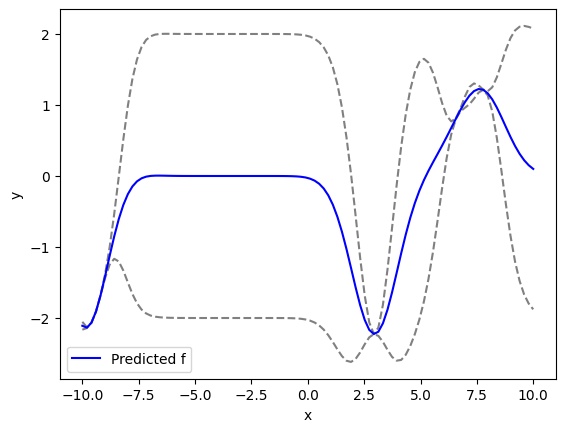

In [32]:
# Get predictions at a dense sampling of points
nstar = 100
Xstar = np.linspace(left_endpoint, right_endpoint, nstar)

# Form covariance matrix between test samples
K22 = np.zeros((nstar, nstar))
for ii in range(nstar):
    for jj in range(nstar):
        curr_k = kernel(Xstar[ii], Xstar[jj])
        K22[ii, jj] = curr_k

# Form covariance matrix between train and test samples
K12 = np.zeros((n, nstar))
for ii in range(K12.shape[0]):
    for jj in range(K12.shape[1]):
        curr_k = gaussian_kernel(X[ii], Xstar[jj])
        K12[ii, jj] = curr_k

K21 = K12.T

# Get predictive distribution mean and covariance


def matrix_inverse(A):
    c = np.linalg.inv(np.linalg.cholesky(A))
    inverse = np.dot(c.T, c)
    return inverse


Ystar_mean = K21 @ matrix_inverse(K11) @ Y
Ystar_cov = K22 - K21 @ matrix_inverse(K11) @ K12

# Sample
Ystar = sp.stats.multivariate_normal(mean=Ystar_mean, cov=Ystar_cov, allow_singular=True).rvs()

plt.plot(Xstar, Ystar_mean + 2 * np.diagonal(Ystar_cov), linestyle="--", color="gray")
plt.plot(Xstar, Ystar_mean - 2 * np.diagonal(Ystar_cov), linestyle="--", color="gray")

plt.plot(Xstar, Ystar_mean, c="blue", label="Predicted f")

plt.xlabel("x")
plt.ylabel("y")
plt.legend()